# Emotion Detection using Convolution Neural Network
**Author**- **Shibani Mukherjeee**

Description- Training a classification model which will classify the human facial expression after training using set of human face images

Dataset- https://www.kaggle.com/datasets/msambare/fer2013 The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

# Setting up kaggle directory

In [1]:
from google.colab import files

# Upload kaggle.json
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 66% 40.0M/60.3M [00:00<00:00, 224MB/s]
100% 60.3M/60.3M [00:00<00:00, 224MB/s]


In [4]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

# Installing packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns
import random

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import tensorflow
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

# Setting up Directory to save model data

In [6]:
os.makedirs('test_dir', exist_ok=True)

In [7]:
# Creating the folder stucture for project and models
project_name = 'Emotion_Detection_FER_2013'
model_name = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Data_Augmentation',
    'VGG_16_Transfer_Learning',
    'Resnet50_Transfer_Learning'
    ]

# base directory
base_dir = '/content/'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok = True)

# Create subdirectories for each model
for each_model in model_name:
  model_dir = os.path.join(project_dir, each_model)
  os.makedirs(model_dir, exist_ok = True)




In [8]:
os.makedirs('Visualization', exist_ok=True)

In [9]:
PLOT_PATH = '/content/Visualization'

In [10]:
print(f'Project directory structure created at: {project_dir}')

Project directory structure created at: /content/Emotion_Detection_FER_2013


# Data Analysis

In [11]:
import os
from collections import Counter
data_dir ='/content/train'

def count_files_by_extension(directory):
    file_counts = Counter()

    for root, dirs, files in os.walk(directory):
        for file in files:
            _, ext = os.path.splitext(file)
            file_counts[ext] += 1

    return file_counts


file_counts = count_files_by_extension(data_dir)

print("File counts by extension:")
for ext, count in file_counts.items():
  print(f"{ext}: {count}")


File counts by extension:
.jpg: 28709


There are no  file extensions available other than .jpg in the train directory

In [12]:
def count_files_in_subdirectories(directory):
    if not os.path.isdir(directory):
        print(f"The directory '{directory}' does not exist.")
        return

    subdirectories = [subdir for subdir in os.listdir(directory) if os.path.isdir(os.path.join(directory, subdir))]

    if not subdirectories:
        print(f"No subdirectories found in '{directory}'.")
        return

    for subdir in subdirectories:
        subdir_path = os.path.join(directory, subdir)
        file_count = sum(len(files) for _, _, files in os.walk(subdir_path))
        print(f"Subdirectory '{subdir}': {file_count} files")


train_dir = '/content/train'
test_dir = '/content/test'
count_files_in_subdirectories(train_dir)
count_files_in_subdirectories(test_dir)


Subdirectory 'angry': 3995 files
Subdirectory 'happy': 7215 files
Subdirectory 'disgust': 436 files
Subdirectory 'sad': 4830 files
Subdirectory 'surprise': 3171 files
Subdirectory 'fear': 4097 files
Subdirectory 'neutral': 4965 files
Subdirectory 'angry': 958 files
Subdirectory 'happy': 1774 files
Subdirectory 'disgust': 111 files
Subdirectory 'sad': 1247 files
Subdirectory 'surprise': 831 files
Subdirectory 'fear': 1024 files
Subdirectory 'neutral': 1233 files


In [13]:
import os
import pandas as pd

def count_files_in_subdirectories(directory):
    if not os.path.isdir(directory):
        print(f"The directory '{directory}' does not exist.")
        return

    subdirectories = [subdir for subdir in os.listdir(directory) if os.path.isdir(os.path.join(directory, subdir))]

    if not subdirectories:
        print(f"No subdirectories found in '{directory}'.")
        return

    data = []
    for subdir in subdirectories:
        subdir_path = os.path.join(directory, subdir)
        file_count = sum(len(files) for _, _, files in os.walk(subdir_path))
        data.append({'Subdirectory': subdir, 'File Count': file_count})

    df = pd.DataFrame(data)
    return df

train_dir = '/content/train'
test_dir = '/content/test'
# count_files_in_subdirectories(train_dir)
df1 = count_files_in_subdirectories(train_dir)
df2 = count_files_in_subdirectories(test_dir)
print('train_dir', df1)
print('test_dir', df2)


train_dir   Subdirectory  File Count
0        angry        3995
1        happy        7215
2      disgust         436
3          sad        4830
4     surprise        3171
5         fear        4097
6      neutral        4965
test_dir   Subdirectory  File Count
0        angry         958
1        happy        1774
2      disgust         111
3          sad        1247
4     surprise         831
5         fear        1024
6      neutral        1233


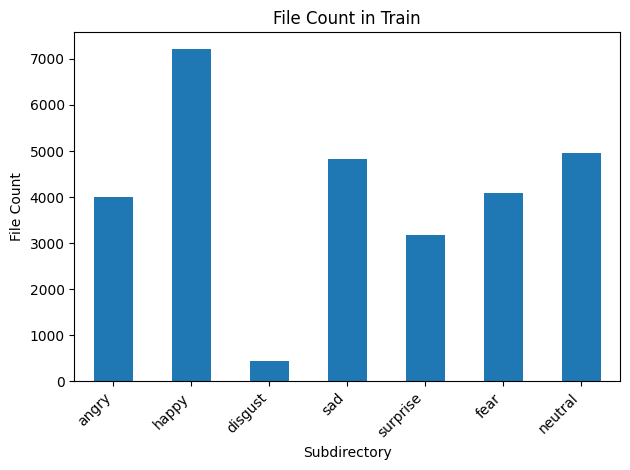

In [14]:
df1.plot(kind='bar', x='Subdirectory', y='File Count', legend=None)
plt.xlabel('Subdirectory')
plt.ylabel('File Count')
plt.title('File Count in Train')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
save_location = PLOT_PATH+'/file_count_in_train.png'
plt.savefig(save_location)
plt.show()

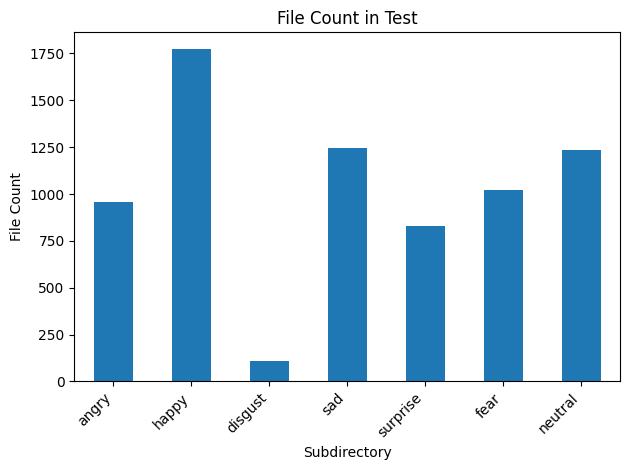

In [15]:
df2.plot(kind='bar', x='Subdirectory', y='File Count', legend=None)
plt.xlabel('Subdirectory')
plt.ylabel('File Count')
plt.title('File Count in Test')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
save_location = PLOT_PATH+'/file_count_in_test.png'
plt.savefig(save_location)
plt.show()

# Plot one image from each subdirectory

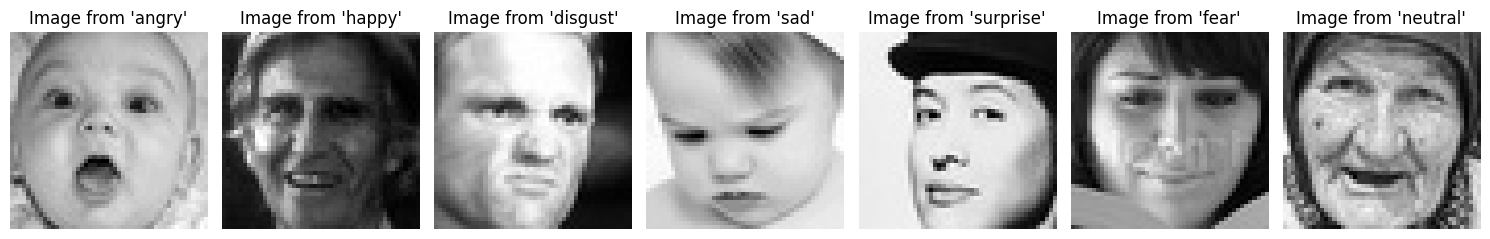

In [16]:
def plot_images_from_subdirectories(directory):
    subdirectories = [subdir for subdir in os.listdir(directory)]
    num_subdirectories = len(subdirectories)
    fig, axes = plt.subplots(1, num_subdirectories, figsize=(15, 5))

    for i, subdir in enumerate(subdirectories):
        subdir_path = os.path.join(directory, subdir)
        image_files = [file for file in os.listdir(subdir_path)]
        image_file = os.path.join(subdir_path, image_files[0])  # Change 0 to whatever index you want
        image = Image.open(image_file)
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Image from '{subdir}'")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


plot_images_from_subdirectories(train_dir)


In [17]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

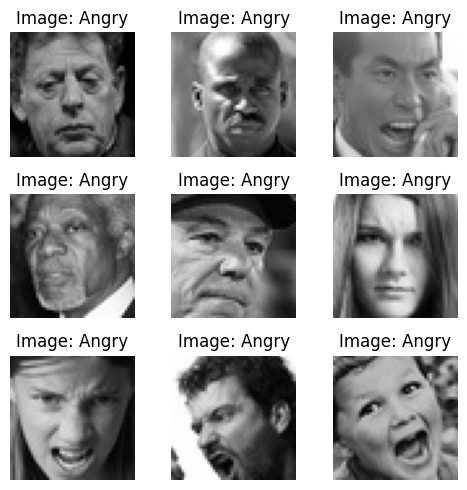

In [18]:
angry_directory_path = '/content/train/angry'  # Replace with your directory path
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

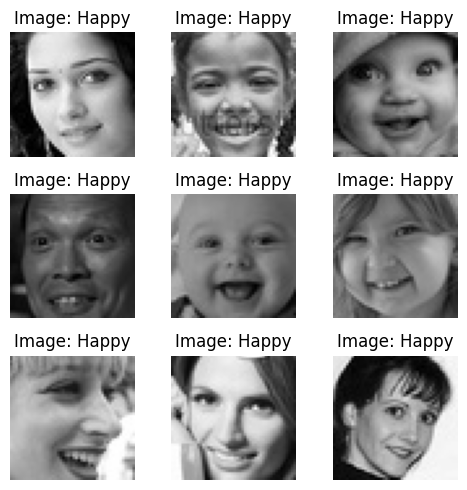

In [19]:
happy_directory_path = '/content/train/happy'  # Replace with your directory path
plot_images_from_directory(happy_directory_path, class_name = 'Happy')

In [20]:
# Cheking the shape and number of channels of an image

image_path = "/content/train/disgust/Training_10371709.jpg"
image = cv2.imread(image_path)
print('Shape is ', image.shape)


Shape is  (48, 48, 3)


In [21]:
image_path = "/content/train/disgust/Training_10371709.jpg"
image = cv2.imread(image_path)
print('Shape is ', image.shape)

img = Image.open(image_path)
width, height = img.size
print("Image size:", width, "x", height)

Shape is  (48, 48, 3)
Image size: 48 x 48


In [22]:
image_path = "/content/train/disgust/Training_10371709.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
print('Shape is ', image.shape)

Shape is  (48, 48)


# 1. Custom CNN from scratch

## Initializing Image Generators

In [ ]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'

In [ ]:
# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7

In [ ]:
# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',)
    # subset='validation')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

# Accessing class labels for the validation data
test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
# Initialising the CNN
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

In [ ]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

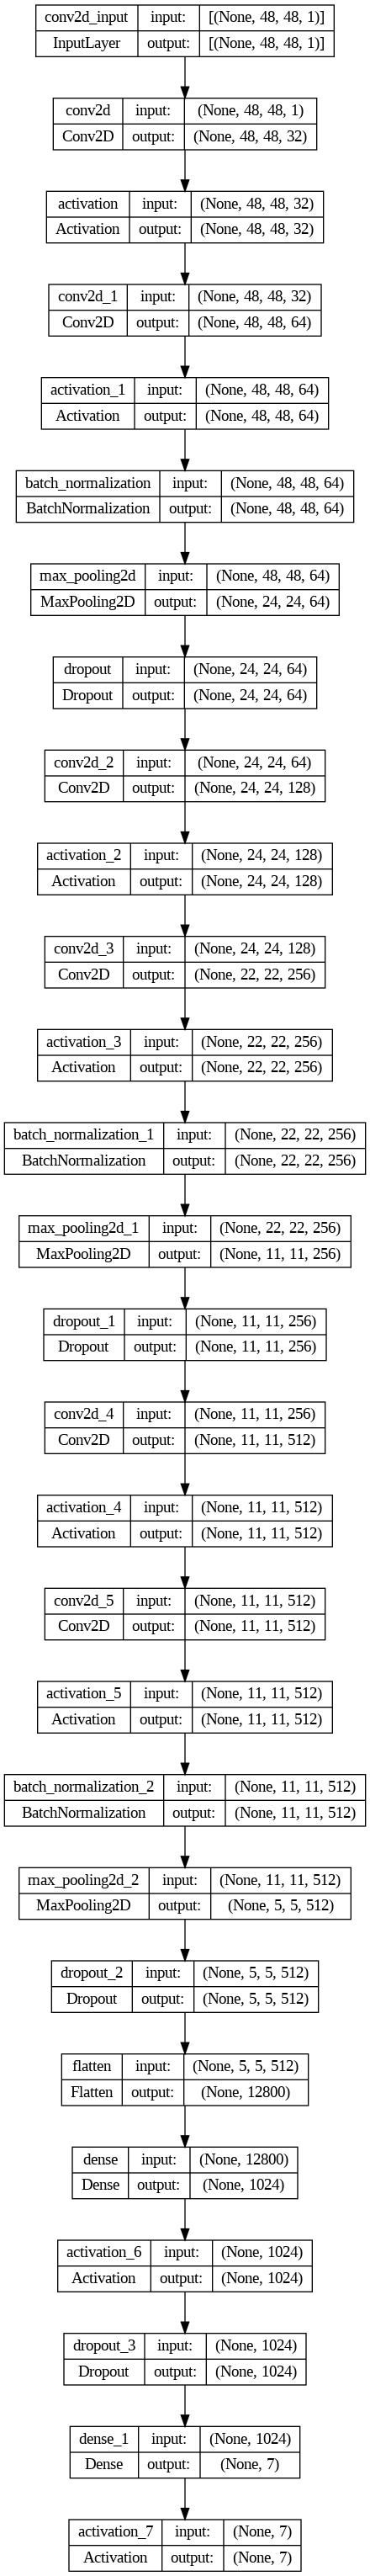

In [ ]:
plot_model(model, to_file = '/content/Emotion_Detection_FER_2013/Custom_CNN_From_Scratch/Architecture.png',
           show_shapes=True, show_layer_names=True)

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/Emotion_Detection_FER_2013/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/Emotion_Detection_FER_2013/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

In [ ]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [ ]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [ ]:
# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

In [ ]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/30
359/359 [==============================] - ETA: 0s - loss: 12.4052 - accuracy: 0.2637
Epoch 1: val_loss improved from inf to 13.58679, saving model to /content/Emotion_Detection_FER_2013/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 [==============================] - 40s 82ms/step - loss: 12.4052 - accuracy: 0.2637 - val_loss: 13.5868 - val_accuracy: 0.0958 - lr: 1.0000e-04
Epoch 2/30
359/359 [==============================] - ETA: 0s - loss: 10.1722 - accuracy: 0.3506
Epoch 2: val_loss improved from 13.58679 to 9.49461, saving model to /content/Emotion_Detection_FER_2013/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 [==============================] - 25s 71ms/step - loss: 10.1722 - accuracy: 0.3506 - val_loss: 9.4946 - val_accuracy: 0.3731 - lr: 1.0000e-04
Epoch 3/30
359/359 [==============================] - ETA: 0s - loss: 8.1306 - accuracy: 0.3912
Epoch 3: val_loss improved from 9.49461 to 7.29736, saving model to /content/Emotion_Detection_FER_2013/Cus

In [ ]:
model.save('/content/Emotion_Detection_FER_2013/Custom_CNN_From_Scratch/Custom_CNN.keras')

# Plotting Performance Metrics

In [ ]:


def plot_history(history):
    fig, axes = plt.subplots(2, 1, figsize=(5, 5))

    # Plot training & validation loss values
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Plot training & validation accuracy values
    axes[1].plot(history.history['accuracy'], label='Train Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_title('Model Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    save_location = PLOT_PATH+'/custom_model_loss_accuracy.png'
    plt.savefig(save_location)
    plt.show()

# Assuming you have already trained your model and have a history object
# model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs)
# where x_train, y_train, x_val, y_val are your training and validation data
# epochs is the number of training epochs

# Then you can call the plot_history function passing the history object
# plot_history(history)



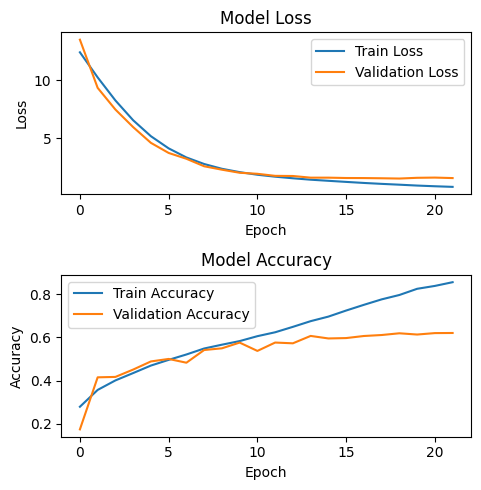

In [ ]:
plot_history(history)

# Model Evaluation

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 4s 36ms/step - loss: 1.4662 - accuracy: 0.6262
final train accuracy = 92.17 , validation accuracy = 62.62


# Ploting Confusion matrix

113/113 [==============================] - 6s 49ms/step


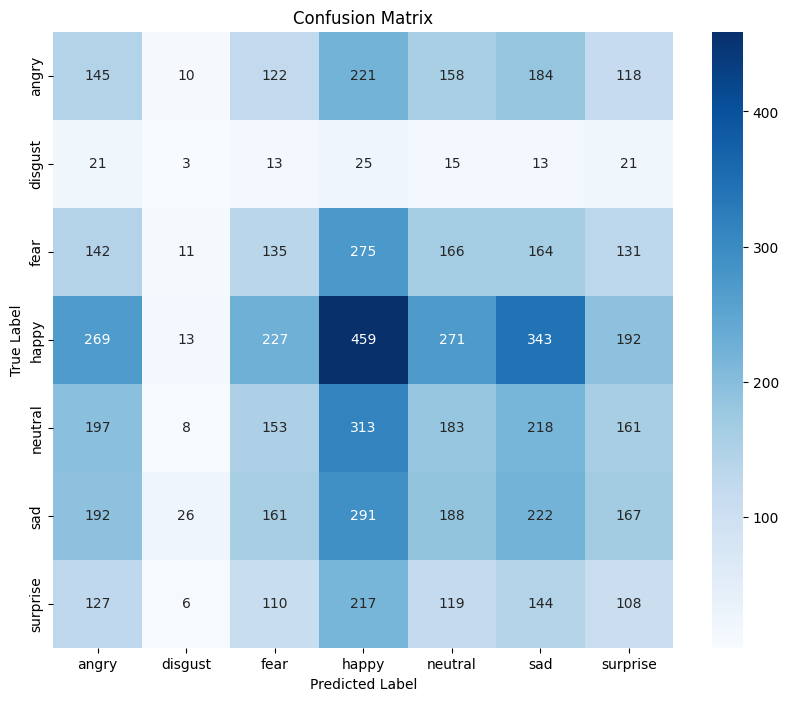

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps = np.ceil(test_generator.samples/test_generator.batch_size)),axis = 1)
class_labels = list(test_generator.class_indices.keys())

#Generate Confusion Matrix
cm =confusion_matrix(true_classes, predicted_classes)

#Ploting with seaborn
plt.figure(figsize = (10,8))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels= class_labels, yticklabels= class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
save_location = PLOT_PATH+'/custom_model_conf_matrix.png'
plt.savefig(save_location)
plt.show()


# Printing Classification Report

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names = class_labels)
print('Classification Report: \n', report)

Classification Report: 
               precision    recall  f1-score   support

       angry       0.13      0.15      0.14       958
     disgust       0.04      0.03      0.03       111
        fear       0.15      0.13      0.14      1024
       happy       0.25      0.26      0.26      1774
     neutral       0.17      0.15      0.16      1233
         sad       0.17      0.18      0.18      1247
    surprise       0.12      0.13      0.12       831

    accuracy                           0.17      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.17      0.17      0.17      7178



# Making Predictions

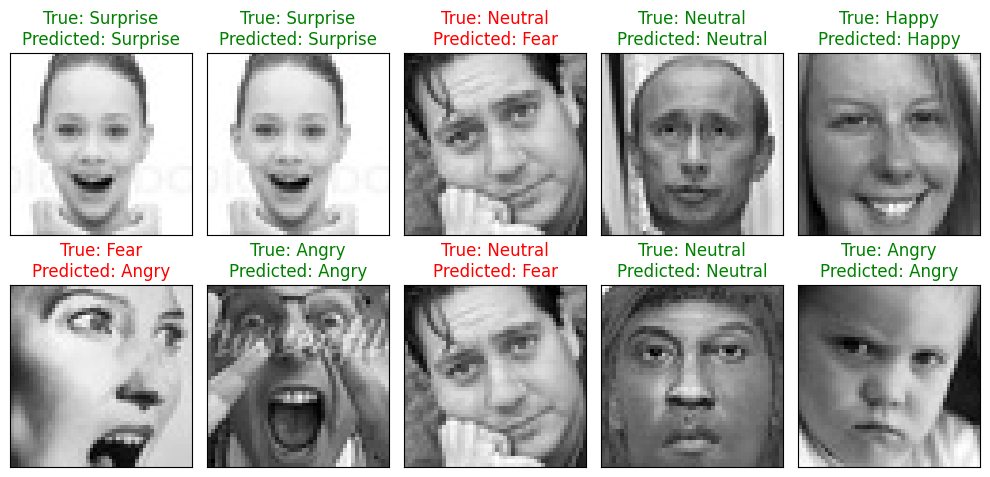

In [ ]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# Model 2 - Image Augmentation with

In [ ]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'

# Set some parameters
img_width, img_height = 224, 224  # Size of images
batch_size = 64
epochs = 10
num_classes = 7


# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale=1./255)


# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


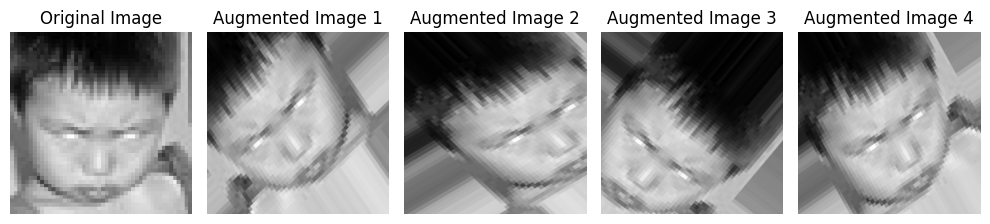

In [ ]:
# Path to your specific image
image_path = '/content/train/angry/Training_10118481.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch

    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Using the same CNN as above

In [ ]:
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

#Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])






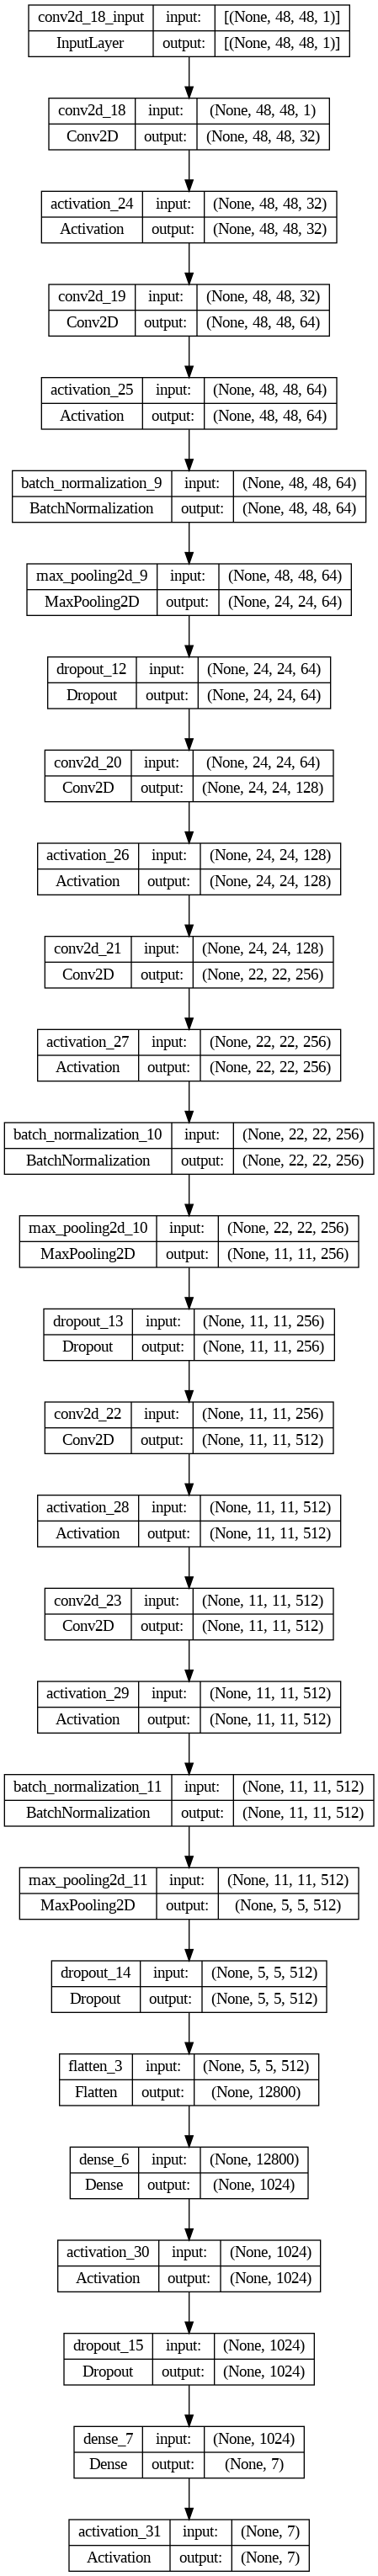

In [ ]:
plot_model(model, to_file = '/content/Emotion_Detection_FER_2013/Custom_CNN_With_Data_Augmentation/Architecture.png',
           show_shapes=True, show_layer_names=True)

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/Emotion_Detection_FER_2013/Custom_CNN_With_Data_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node sequential_3/dense_6/MatMul defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-55-2a5f106dd977>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py", line 241, in call

Matrix size-incompatible: In[0]: [64,373248], In[1]: [12800,1024]
	 [[{{node sequential_3/dense_6/MatMul}}]] [Op:__inference_train_function_64204]

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

# Model 3- Transfer Learning-VGG16

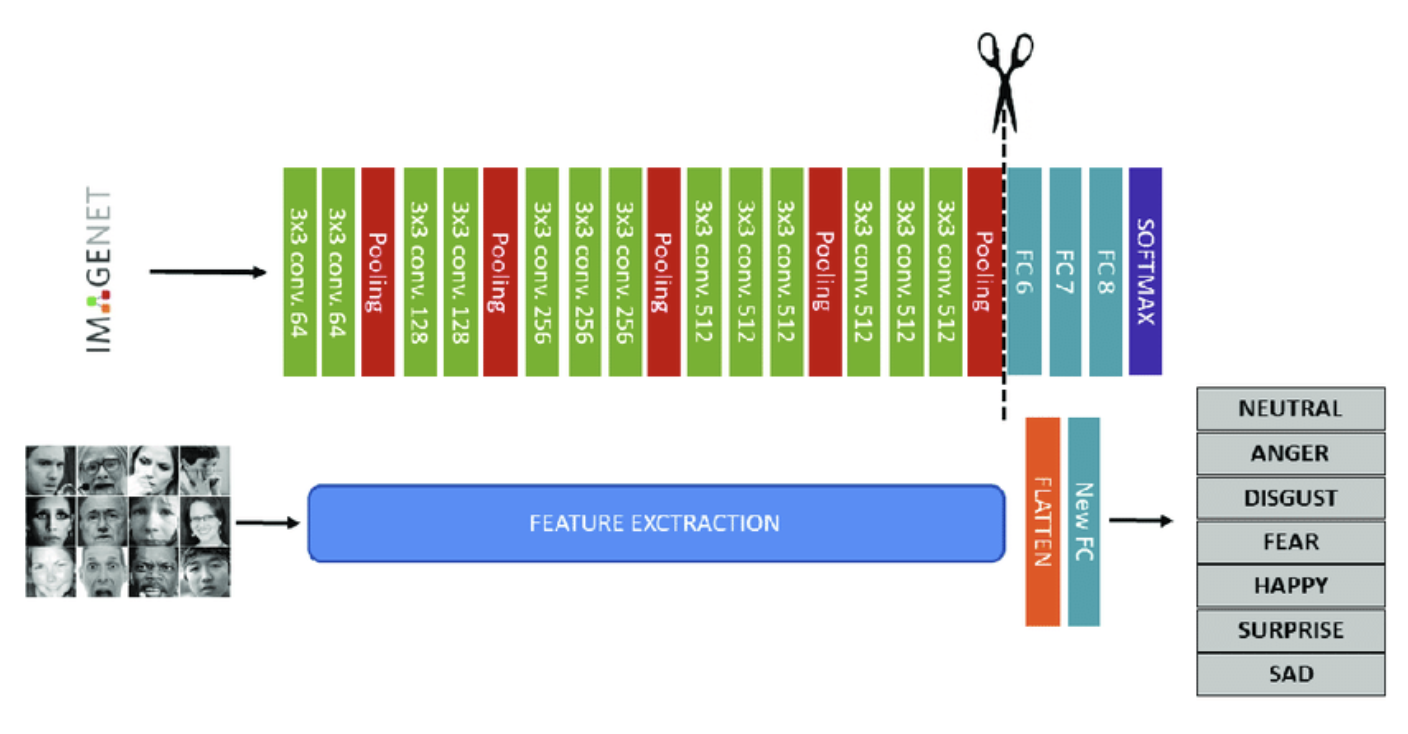

In [ ]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'

# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 224, 224  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                # validation_split=0.2
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
                                train_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',)
                                # subset='validation')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
classes = 7

# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
    layer.trainable = False

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(7, activation='softmax', kernel_initializer='he_normal')(x)

# Creating the model
model = Model(inputs=vgg.input, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

# Model summary to see all layers
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/Emotion_Detection_FER_2013/VGG_16_Transfer_Learning'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

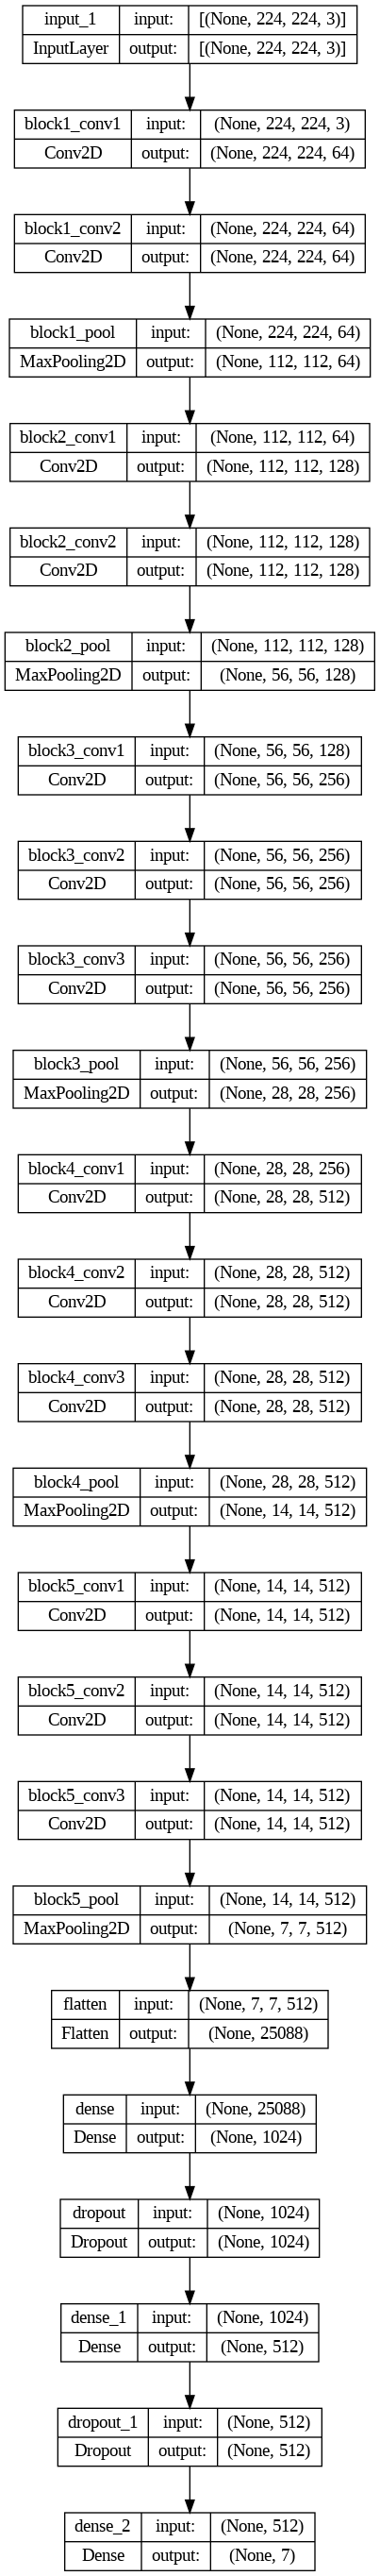

In [ ]:
plot_model(model, to_file = '/content/Emotion_Detection_FER_2013/VGG_16_Transfer_Learning/Architecture.png',
           show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=50,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    class_weight=class_weights_dict,
                    callbacks = callbacks
                    )

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 1.8322 - accuracy: 0.2650
Epoch 1: val_loss improved from inf to 1.73238, saving model to /content/Emotion_Detection_FER_2013/VGG_16_Transfer_Learning/VGG16_Transfer_Learning.keras
449/449 [==============================] - 443s 955ms/step - loss: 1.8322 - accuracy: 0.2650 - val_loss: 1.7324 - val_accuracy: 0.2618 - lr: 1.0000e-04
Epoch 2/50
449/449 [==============================] - ETA: 0s - loss: 1.5846 - accuracy: 0.3871
Epoch 2: val_loss improved from 1.73238 to 1.52519, saving model to /content/Emotion_Detection_FER_2013/VGG_16_Transfer_Learning/VGG16_Transfer_Learning.keras
449/449 [==============================] - 437s 973ms/step - loss: 1.5846 - accuracy: 0.3871 - val_loss: 1.5252 - val_accuracy: 0.4122 - lr: 1.0000e-04
Epoch 3/50
449/449 [==============================] - ETA: 0s - loss: 1.4776 - accuracy: 0.4285
Epoch 3: val_loss improved from 1.52519 to 1.41568, saving model to /content/Emotion_Detection

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

# Model 4- Transfer Leanring - ResNet50

In [27]:
# Directory paths for training and testing data
train_dir = '/content/train'
test_dir = '/content/test'

# Batch size for data generators
batch_size = 64

# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(
                                  rescale=1 / 255.,  # Rescale pixel values to [0,1]
                                  rotation_range=10,  # Random rotation within range [-10,10] degrees
                                  zoom_range=0.2,  # Random zoom between [0.8, 1.2]
                                  width_shift_range=0.1,  # Random horizontal shift within range [-0.1, 0.1]
                                  height_shift_range=0.1,  # Random vertical shift within range [-0.1, 0.1]
                                  horizontal_flip=True,  # Random horizontal flip
                                  fill_mode='nearest'  # Fill mode for handling newly created pixels
                                 )

# Configuration for testing data (only rescaling)
test_datagen = ImageDataGenerator(
                                  rescale=1 / 255.  # Rescale pixel values to [0,1]
                                 )

# Data generators for training and testing data
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,  # Directory containing training data
                                                    class_mode="categorical",  # Classification mode for categorical labels
                                                    target_size=(224, 224),  # Resize input images to (224,224)
                                                    color_mode='rgb',  # Color mode for images (RGB)
                                                    shuffle=True,  # Shuffle training data
                                                    batch_size=batch_size,  # Batch size for training
                                                    subset='training'  # Subset of data (training)
                                                   )

test_generator = test_datagen.flow_from_directory(
                                                  test_dir,  # Directory containing testing data
                                                  class_mode="categorical",  # Classification mode for categorical labels
                                                  target_size=(224, 224),  # Resize input images to (224,224)
                                                  color_mode="rgb",  # Color mode for images (RGB)
                                                  shuffle=False,  # Do not shuffle testing data
                                                  batch_size=batch_size  # Batch size for testing
                                                 )


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Introducing Class wieghts for imbalanced data

In [28]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [29]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

94668760/94668760 [==============================] - 1s 0us/step


In [30]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [31]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [32]:
model = Create_ResNet50V2_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [33]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# File path for the model checkpoint
cnn_path = '/content/Emotion_Detection_FER_2013/Resnet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
#                             min_lr=0.00005,
                              verbose=1)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
train_history = model.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=30,
                          validation_data=test_generator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                         )

Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 1.7176 - accuracy: 0.3798
Epoch 1: val_loss improved from inf to 1.45782, saving model to /content/Emotion_Detection_FER_2013/Resnet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
449/449 [==============================] - 417s 887ms/step - loss: 1.7176 - accuracy: 0.3798 - val_loss: 1.4578 - val_accuracy: 0.4830
Epoch 2/30
449/449 [==============================] - ETA: 0s - loss: 1.4419 - accuracy: 0.4784
Epoch 2: val_loss improved from 1.45782 to 1.31985, saving model to /content/Emotion_Detection_FER_2013/Resnet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
449/449 [==============================] - 399s 888ms/step - loss: 1.4419 - accuracy: 0.4784 - val_loss: 1.3199 - val_accuracy: 0.5188
Epoch 3/30
449/449 [==============================] - ETA: 0s - loss: 1.2566 - accuracy: 0.5323
Epoch 3: val_loss improved from 1.31985 to 1.12670, saving model to /content/Emotion_Detection_FER_2013/Resnet50_Trans

KeyboardInterrupt: 

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import shutil
# Define the source and destination paths
destination_folder = '/content/drive/MyDrive/Emotion_Detection_FER_2013'
source_folder = '/content/Emotion_Detection_FER_2013'

# Remove the existing destination folder if it exists
if os.path.exists(destination_folder):
    shutil.rmtree(destination_folder)

# Copy the folder and its contents recursively
shutil.copytree(source_folder, destination_folder)

print("Folder copied successfully!")

Folder copied successfully!


In [ ]:
plot_training_history(train_history)

In [25]:
import keras

In [26]:
model = keras.saving.load_model("/content/drive/MyDrive/Emotion_Detection_FER_2013/Resnet50_Transfer_Learning/new_Resnet50_model2.keras")

In [35]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 20s 175ms/step - loss: 2.9068 - accuracy: 0.1234
final train accuracy = 11.62 , validation accuracy = 12.34


113/113 [==============================] - 20s 168ms/step


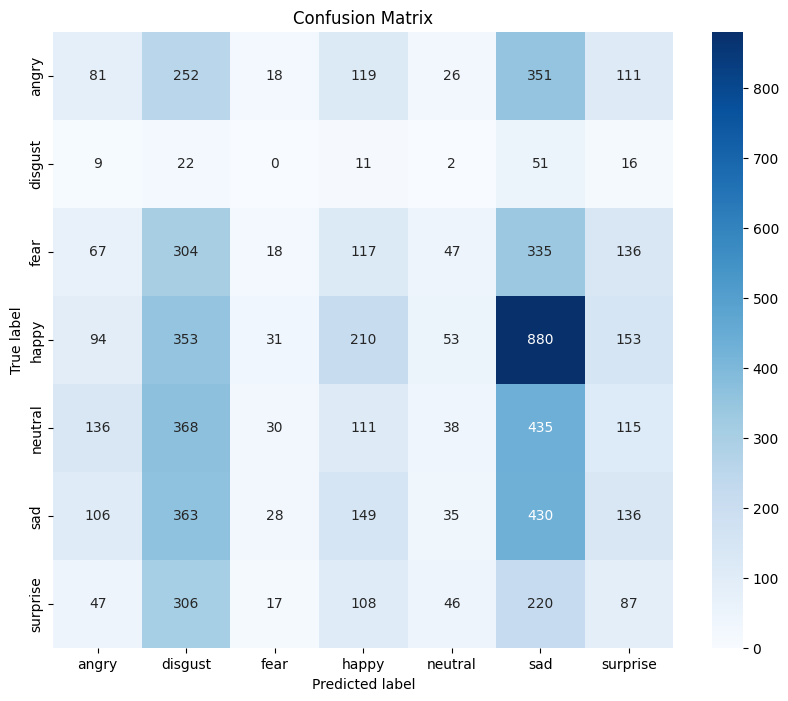

In [36]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [37]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.15      0.08      0.11       958
     disgust       0.01      0.20      0.02       111
        fear       0.13      0.02      0.03      1024
       happy       0.25      0.12      0.16      1774
     neutral       0.15      0.03      0.05      1233
         sad       0.16      0.34      0.22      1247
    surprise       0.12      0.10      0.11       831

    accuracy                           0.12      7178
   macro avg       0.14      0.13      0.10      7178
weighted avg       0.17      0.12      0.12      7178



# AUC ROC plot for each class

In [38]:
true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

113/113 [==============================] - 19s 167ms/step


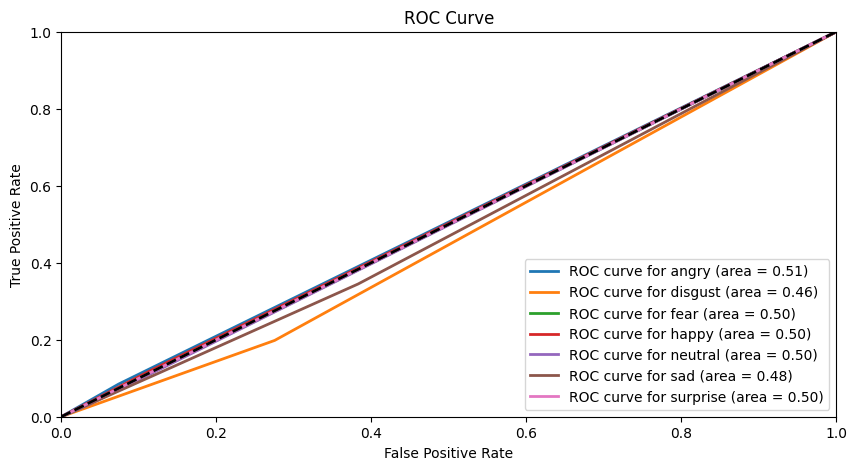

In [39]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')